# Quickstart

In this tutorial, we will build a [crossover strategy](https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp) that exclusively buys and sells JNUG. It will enter a long position whenever the price goes above its 20-day MA and enter a short position when it goes below.

## Building a Backtest
Use [BacktesterBuilder](../api/simple_back.html#simple_back.backtester.BacktesterBuilder) to configure and create a [Backtester](#) object.

In [1]:
from glob import glob
import re
import json

hrefs = re.compile('href="#([^"]+)"')

refs = []

with open('../_build/html/api/simple_back.html') as api:
    refs += hrefs.findall(api.read())
        
refs = set(refs)

In [2]:
def find_ref(x):
    for r in refs:
        if r.endswith(x):
            return r

In [14]:
import json

link = re.compile('\[`([^\]`]*)`\][^(]')

for file in glob('../../docs/**/*.ipynb', recursive=True):
    if '_build' not in file:
        print(file)
        with open(file) as api:
            j_file_content = json.loads(api.read())
            for i, cell in enumerate(j_file_content['cells']):
                if cell['cell_type'] == 'markdown':
                    for j, line in enumerate(cell['source']):
                        for match in link.findall(line):
                            level = file.split('docs/')[1].count('/')
                            base = ''.join(['../']*level)
                            base += 'api/simple_back.html'
                            line = line.replace(
                                f'[`{match}`]', 
                                f'[`{match}`]({base}#{find_ref(match.replace('()', ''))})'
                            )
                            class_str = find_ref(match)
                            to_replace =f"""
                                         <a class="reference internal" \
                                         href="../api/simple_back.html#{class_str}" \
                                         title="{class_str}">\
                                         <code class="xref py py-class docutils literal notranslate">\
                                         <span class="pre">{match}</span></code></a>
                                         """
                            j_file_content['cells'][i]['source'][j] = line
            with open(file, 'w') as outfile:
                json.dump(j_file_content, outfile)

../../docs/usage_examples.ipynb
{'cells': [{'cell_type': 'markdown', 'metadata': {}, 'source': ['# Backtesting\n', '### Price\n', 'Use ``price`` to get the current price of a symbol. Given a number, it will go back that amount of days, which can be used to compute averages, etc.\n', '\n', '### Available Capital & Capital\n', 'While ``capital`` is the current value of your portfolio + cash, ``available_capital`` is capital not tied up in securities only.\n', '\n', '### Order\n', 'Use ``order`` to enter a long trade of the given ticker, using the given funds (either use an absolute number or a percentage when passing ``as_percent=True``). To enter a short position, pass ``short=True``.\n', '\n', '### Portfolio\n', '``portfolio`` is a dataframe that contains information about all currently held positions.\n', '\n', '### Liquidate\n', 'Use ``liquidate`` to get out of positions. Simply pass a filter for ``portfolio`` and all entries matching it will be liquidated.']}, {'cell_type': 'raw', '

In [10]:
from simple_back.backtester import BacktesterBuilder

bt = (
   BacktesterBuilder()
   .name('JNUG 20-Day Crossover')
   .balance(10_000)
   .calendar('NYSE')
   .compare(['JNUG']) # strategies to compare with
   .live_plot() # we assume we are running this in a Jupyter Notebook
   .live_progress()
   .build()
)

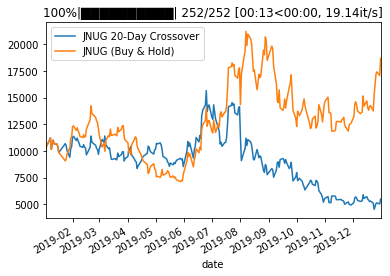

In [11]:
for day, event, b in bt['2019-1-1':'2020-1-1']:
    if event == 'open':
        jnug_ma = b.prices['JNUG',-20:]['close'].mean()

        if b.price('JNUG') > jnug_ma:
            if not b.portfolio['JNUG'].long: # check if we already are long JNUG
                b.portfolio['JNUG'].short.liquidate() # liquidate any/all short JNUG positions
                b.order_pct('JNUG', 1) # long JNU

        if b.price('JNUG') < jnug_ma:
            if not b.portfolio['JNUG'].short: # check if we already are short JNUG
                b.portfolio['JNUG'].long.liquidate() # liquidate any/all long JNUG positions
                b.order_pct('JNUG', -1) # short JNUG